In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
FOLDERNAME = 'Colab Notebooks/RLHF_final'
%cd /content/drive/My\ Drive/$FOLDERNAME/
!ls

/content/drive/My Drive/Colab Notebooks/RLHF_final
best_model_final.h5  best_model.h5  data  extract_features.py  load_data.py  __pycache__


In [ ]:
!python extract_features.py

Namespace(json_file='data/result.json', start_index=1000, end_index=1520, batch_size=64)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100% 171M/171M [00:01<00:00, 165MB/s]
Extracting features: 100% 33/33 [00:11<00:00,  2.94it/s]
im1_features shape: (2084, 2048, 1, 1)
Extracting featur

In [ ]:
%cd /content/drive/My\ Drive/$FOLDERNAME/
from load_data import load_json_data

# Load data
data = load_json_data("data/result.json", 1000, 1519)
data[-1]

/content/drive/My Drive/Colab Notebooks/RLHF_final


[{'filename': '03573_0',
  'sentence1': 'A building has been constructed on the empty area at the edge of the scene ',
  'sentence2': 'The roof of the buildings at the edge of the scene has turned from blue to gray ',
  'sentence3': 'the roof of the buildings at the edge of the scene has turned from blue to gray ',
  'slider1': -5,
  'slider2': -2,
  'slider3': -2},
 {'filename': '03573_1',
  'sentence1': 'A building has been constructed on the green area at the edge of the scene ',
  'sentence2': 'The blue building at the edge of the scene has turned blue ',
  'sentence3': 'The green area at the edge of the scene has turned blue ',
  'slider1': 4,
  'slider2': -5,
  'slider3': 1},
 {'filename': '03573_2',
  'sentence1': 'many trees appear on the bareland at the corner of the scene ',
  'sentence2': 'the bareland appears on the edge of the scene ',
  'sentence3': 'bareland appears on the buildings at the corner of the scene ',
  'slider1': -5,
  'slider2': -4,
  'slider3': -5},
 {'file

In [ ]:
import numpy as np

features_im1 = np.load(f"data/features/im1.npy")

features_im1 = features_im1.reshape((2084, 2048))

features_im2 = np.load(f"data/features/im2.npy")

features_im2 = features_im2.reshape((2084, 2048))

features_im1.shape, features_im2.shape

((2084, 2048), (2084, 2048))

#### Encoding The Sentences With BERT model

In [ ]:
import numpy as np
import torch
import tqdm
from transformers import BertTokenizer, BertModel
import os

if os.path.exists("data/features/sentence_embeddings.npy"):
    sentence_embeddings = np.load("data/features/sentence_embeddings.npy")
    sentence_embeddings.shape
    print("Sentence embeddings loaded from file")
else:

  def bert_encode(sentences, bert_model, tokenizer, device, batch_size=32):
      bert_model.to(device)
      bert_model.eval()  # Modeli değerlendirme modunda çalıştır

      # Tüm cümleleri batch'ler halinde işle
      all_sentence_embeddings = []
      for i in tqdm.tqdm(range(0, len(sentences), batch_size), desc="BERT Encoding"):
          batch_sentences = sentences[i:i+batch_size]
          encoded = tokenizer.batch_encode_plus(
              batch_sentences,
              add_special_tokens=True,
              max_length=512,
              padding='max_length',
              truncation=True,
              return_attention_mask=True,
              return_tensors='pt'
          )

          input_ids = encoded['input_ids'].to(device)
          attention_mask = encoded['attention_mask'].to(device)

          with torch.no_grad():
              outputs = bert_model(input_ids, attention_mask=attention_mask)
              sentence_embeddings = outputs[0][:, 0, :]  # [CLS] token'ın çıktısını al
              all_sentence_embeddings.extend(sentence_embeddings.cpu().numpy())

      return np.array(all_sentence_embeddings)

  def collect_all_sentences(data):
      all_sentences = []
      sentence_lengths = []
      for data_point in data:
          for data_point_caption in data_point:
              for i in range(1, 4):
                  all_sentences.append(data_point_caption["sentence" + str(i)])
      return all_sentences


  # Load BERT model
  bert_model = BertModel.from_pretrained('bert-base-uncased')
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Collect all sentences
  all_sentences = collect_all_sentences(data)

  # Encode sentences
  sentence_embeddings = bert_encode(all_sentences, bert_model, tokenizer, device, batch_size=128)

  #free gpu memory
  if torch.cuda.is_available():
      torch.cuda.empty_cache()

  import os
  if not os.path.exists("data/features"):
      os.makedirs("data/features")
  np.save("data/features/sentence_embeddings.npy", sentence_embeddings)


  sentence_embeddings.shape

Sentence embeddings loaded from file


#### Prepare Training Data

In [ ]:
combined_features = []
combined_labels = []
slider_values = []

for data_point in data:
    for i in range(0, 4):
        for j in range(1, 4):
            slider_values.append(data_point[i]["slider" + str(j)])

slider_values = np.array(slider_values)
slider_values.shape

(6252,)

#### Categorize the data between 0 and 2
* If you want to reduce prediction range then run given below cell

In [ ]:
def categorize_labels(value):
    if value <= -2:
        return 0
    elif value >= 2:
        return 2
    else:
        return 1

slider_values = np.array([categorize_labels(value) for value in slider_values])
slider_values[0]

2

### Section 1
#### If you want to create neural network using combined data then run below cell
* If you want to create it seperately, then go to section 2

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.nn.functional import normalize

# Assuming the following shapes
# before_feature.shape = (2084, 2048)
# after_feature.shape = (2084, 2048)
# bert_encoded_sentences.shape = (6252, 768)
# slider_values.shape = (6252,)

before_features_tensor = torch.tensor(features_im1, dtype=torch.float32)
after_features_tensor = torch.tensor(features_im2, dtype=torch.float32)
bert_encoded_sentences_tensor = torch.tensor(sentence_embeddings, dtype=torch.float32)

before_features_norm = normalize(before_features_tensor, p = 2, dim = 1)
after_features_norm = normalize(after_features_tensor, p = 2, dim = 1)
sentences_norm = normalize(bert_encoded_sentences_tensor, p=2, dim=1)

before_features_repeated = before_features_norm.repeat_interleave(3, dim=0)
after_features_repeated = after_features_norm.repeat_interleave(3, dim=0)

combined_features = torch.cat([before_features_repeated, after_features_repeated, sentences_norm], dim = 1)

combined_features = combined_features.numpy()

# Shuffle and split the data
X_train, X_testVal, y_train, y_testVal = train_test_split(combined_features, slider_values, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_testVal, y_testVal, test_size=0.66, random_state=42, shuffle=True)

combined_features.shape

(6252, 4864)

#### Scaling The Data
* If you've already used normalizing the data via pytorch, don't use the StandardScaler

In [ ]:
# Scale the data
#TODO: torch normalize

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_test[0]

array([-0.8220586 , -0.84335107,  1.2922608 , ...,  0.2619933 ,
        0.7300415 ,  0.24618685], dtype=float32)

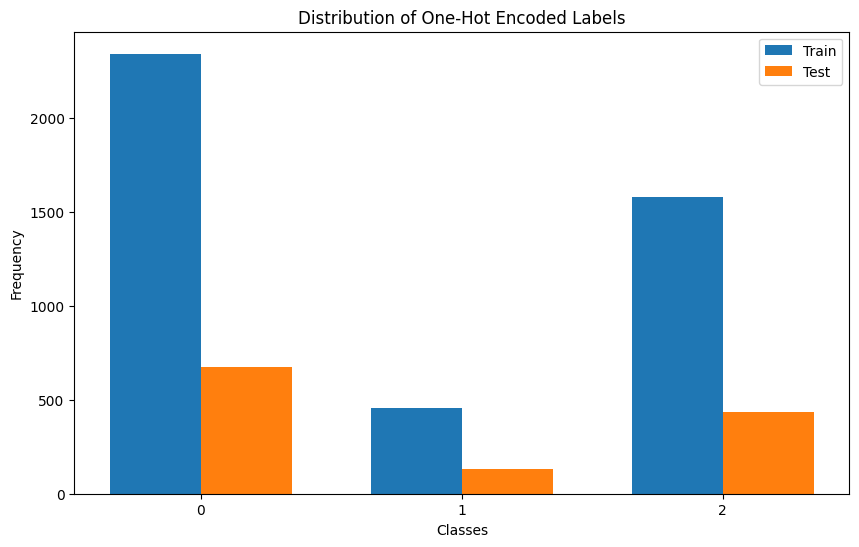

In [ ]:
# cover label to the categorical if necessary
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

y_train_categorical = to_categorical(y_train, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)
y_val_categorical = to_categorical(y_val)

train_distr = np.sum(y_train_categorical, axis=0)
test_distr = np.sum(y_test_categorical, axis=0)

# Set the labels for the classes
classes = ['0', '1', '2']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create bar positions
bar_width = 0.35
indices = np.arange(len(classes))

# Plotting both distributions side by side
train_bar = ax.bar(indices, train_distr, bar_width, label='Train')
test_bar = ax.bar(indices + bar_width, test_distr, bar_width, label='Test')

# Labeling
ax.set_xlabel('Classes')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of One-Hot Encoded Labels')
ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels(classes)
ax.legend()

# Display
plt.show()

#### Random Forest Regressor Approach

In [ ]:
# Random forest Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

rf_regressor = RandomForestRegressor(random_state=42, n_estimators=200, n_jobs=-1)

rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 10.33164139507838


#### XGBoost Model Approach

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

xgb_reg = xgb.XGBRegressor(tree_method='hist', device='cuda' if torch.cuda.is_available() else 'cpu', random_state=42)

# Train the model
xgb_reg.fit(X_train, y_train)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.0001, 0.001, 0.01],
    'subsample': [0.8, 1]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=2)

# Perform grid search
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print(best_model)

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Optimized Mean Squared Error: {mse}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:50:00] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.0001, max_depth=3, n_estimators=100, subsample=0.8; total time=   5.8s
[CV] END learning_rate=0.0001, max_depth=3, n_estimators=100, subsample=0.8; total time=   6.8s
[CV] END learning_rate=0.0001, max_depth=3, n_estimators=100, subsample=0.8; total time=   6.6s
[CV] END learning_rate=0.0001, max_depth=3, n_estimators=100, subsample=1; total time=   5.9s
[CV] END learning_rate=0.0001, max_depth=3, n_estimators=100, subsample=1; total time=   7.0s
[CV] END learning_rate=0.0001, max_depth=3, n_estimators=100, subsample=1; total time=   6.3s
[CV] END learning_rate=0.0001, max_depth=3, n_estimators=300, subsample=0.8; total time=  10.5s
[CV] END learning_rate=0.0001, max_depth=3, n_estimators=300, subsample=0.8; total time=   9.2s
[CV] END learning_rate=0.0001, max_depth=3, n_estimators=300, subsample=0.8; total time=   9.8s
[CV] END learning_rate=0.0001, max_depth=3, n_estimators=300, subsample=1; total time=   9.6s
[CV] END learning_rate=0.0001, max_depth=3, n_es

#### XGboost for classification

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train_categorical)

# Evaluate the model
accuracy = xgb_model.score(X_test, y_test_categorical)

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 0.54%


#### KNN for classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train_categorical)

# Evaluate the model
accuracy = knn_model.score(X_test, y_test_categorical)

print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 0.47%


#### Support Vector Regularization

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'epsilon': [0.01, 0.1, 0.5, 1],  # Margin of tolerance
    'kernel': ['rbf', 'linear', 'poly']  # Kernel type
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

best_svr = grid_search.best_estimator_

print(best_svr)

# Make predictions with the best model
y_pred = best_svr.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Optimized Mean Squared Error: {mse}")
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time= 1.9min
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time= 1.7min
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time= 1.7min
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time= 1.7min
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time= 1.7min
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time= 1.5min
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time= 1.6min
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time= 1.6min
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time= 1.5min
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time= 1.5min
[CV] END ...................C=0.1, epsilon=0.01, kernel=poly; total time= 1.5min
[CV] END ...................C=0.1, epsilon=0.01

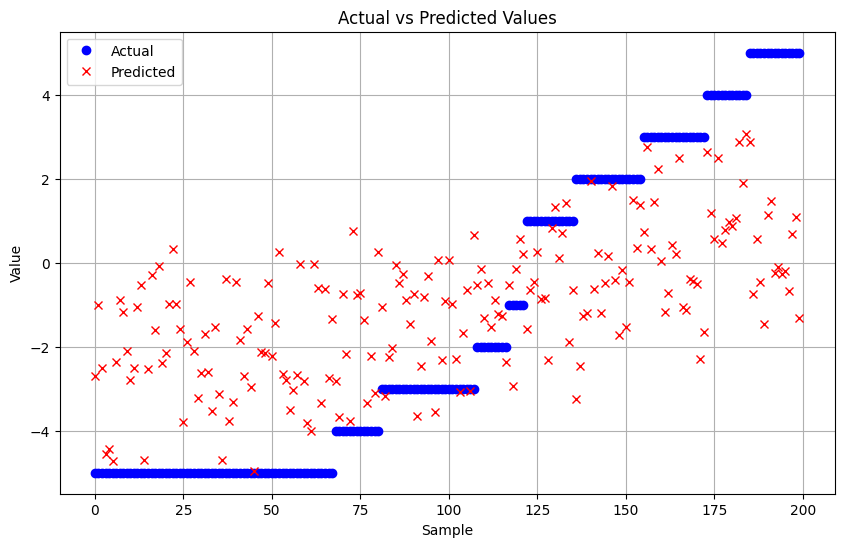

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_actual_vs_predicted(y_actual, y_predicted, n_samples):
    """
    Plots actual vs predicted values for a given number of samples.

    :param y_actual: Array of actual values.
    :param y_predicted: Array of predicted values.
    :param n_samples: Number of samples to plot.
    """
    # Randomly select N samples
    indices = np.random.choice(len(y_actual), n_samples, replace=False)

    # Sort these samples by actual values for better visualization
    sorted_indices = indices[np.argsort(y_actual[indices])]

    # Extract the actual and predicted values for these indices
    actual = y_actual[sorted_indices]
    predicted = y_predicted[sorted_indices]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(actual, 'o', label='Actual', color='blue')
    plt.plot(predicted, 'x', label='Predicted', color='red')

    # Adding titles and labels
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with your actual and predicted values
plot_actual_vs_predicted(y_test, y_pred, n_samples=200)

In [ ]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Check if TensorFlow is able to recognize the GPU
if tf.test.gpu_device_name():
    print(f"Default GPU Device: {tf.test.gpu_device_name()}")
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


#### Oversampling the minority classes

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# If y_train is one-hot encoded, convert it to single labels
# Assumes y_train_categorical is an array of one-hot encoded labels
y_train_labels = np.argmax(y_train_categorical, axis=1)

# Initialize SMOTE
smote = SMOTE()

# Fit SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_labels)

y_train_smote_categorical = tf.keras.utils.to_categorical(y_train_smote, num_classes=3)

y_train_smote_categorical.shape

(7023, 3)

#### Train The Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

model = Sequential()

# Adjusted model architecture
model.add(Dense(1024, input_dim=4864, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(3, activation="softmax"))

# Compile model with adjusted learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Summary
model.summary()

# Fit model
history = model.fit(
    X_train, y_train_categorical,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val_categorical),
    callbacks=[early_stop, model_checkpoint],
     class_weight=class_weight_dict
)

loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1024)              4981760   
                                                                 
 batch_normalization_4 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 1024)              0         
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_5 (Bat  (None, 512)               2048      
 chNormalization)                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


137/137 [==============================] - 10s 27ms/step - loss: 4.2178 - accuracy: 0.3423 - val_loss: 4.0356 - val_accuracy: 0.1915
Epoch 2/500
137/137 [==============================] - 2s 17ms/step - loss: 4.1153 - accuracy: 0.3563 - val_loss: 4.0474 - val_accuracy: 0.2606
Epoch 3/500
137/137 [==============================] - 4s 26ms/step - loss: 4.0456 - accuracy: 0.3716 - val_loss: 3.9844 - val_accuracy: 0.3328
Epoch 4/500
137/137 [==============================] - 3s 23ms/step - loss: 3.9720 - accuracy: 0.3999 - val_loss: 3.9201 - val_accuracy: 0.3673
Epoch 5/500
137/137 [==============================] - 2s 18ms/step - loss: 3.9089 - accuracy: 0.4255 - val_loss: 3.8724 - val_accuracy: 0.4333
Epoch 6/500
137/137 [==============================] - 2s 11ms/step - loss: 3.8645 - accuracy: 0.4372 - val_loss: 3.8215 - val_accuracy: 0.4553
Epoch 7/500
137/137 [==============================] - 2s 11ms/step - loss: 3.7996 - accuracy: 0.4767 - val_loss: 3.8065 - val_accuracy: 0.4804
Epo

KeyError: ignored

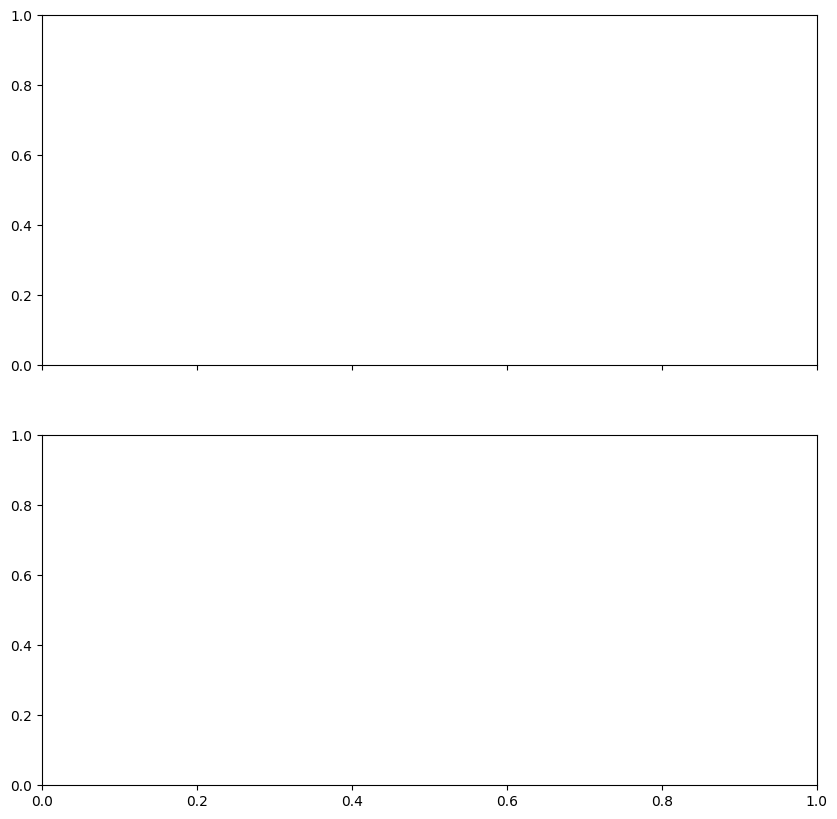

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert model history into a Pandas DataFrame
losses_df = pd.DataFrame(model.history.history)

# Plot the losses and MSE on separate subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# Loss plot
axes[0].plot(losses_df['loss'], label='Training Loss')
axes[0].plot(losses_df['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_yscale('log')

# MSE plot
axes[1].plot(losses_df['mean_absolute_error'], label='Training MAE', linestyle='--')
axes[1].plot(losses_df['val_mean_absolute_error'], label='Validation MAE', linestyle='--')
axes[1].set_title('Training and Validation MAE')
axes[1].set_ylabel('MAE')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].set_yscale('log')

# Show the plot
plt.show()


40/40 [==============================] - 0s 3ms/step
Mean Squared Error: 14.200888750964598
Mean Absolute Error: 2.5462529238024585


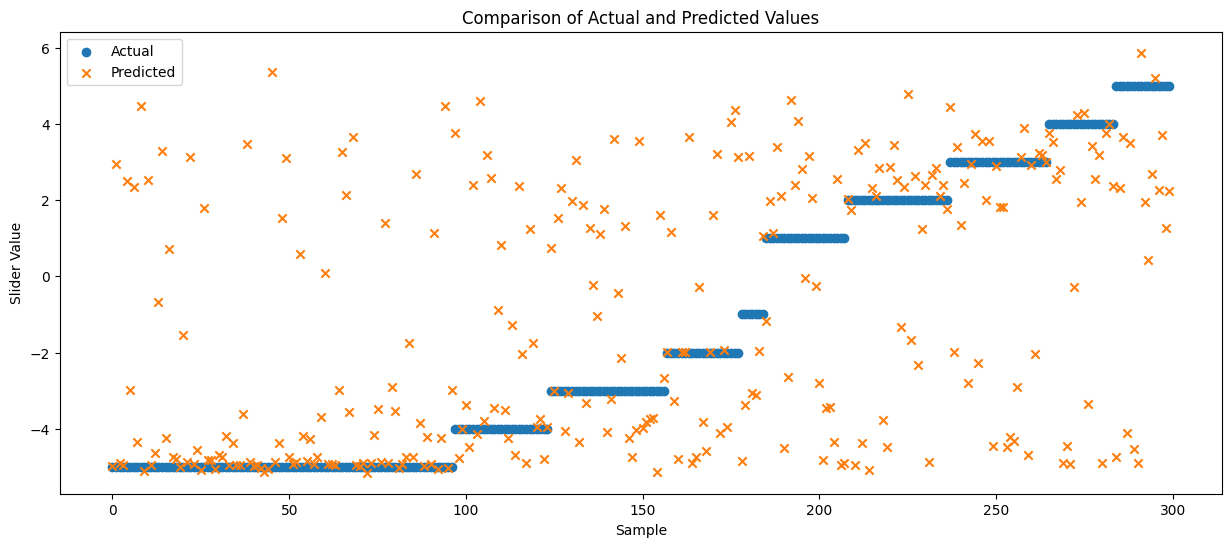

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred = model.predict(X_test).flatten()

# Calculate MSE and MAE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# Sort by actual values while keeping track of predictions
N = 300
sorted_indices = np.argsort(y_test[:N])
sorted_actual = y_test[sorted_indices]
sorted_predicted = y_pred[sorted_indices]

# Plotting the first N test samples for comparison after sorting
plt.figure(figsize=(15, 6))
plt.scatter(range(N), sorted_actual, label='Actual', marker='o')
plt.scatter(range(N), sorted_predicted, label='Predicted', marker='x')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Slider Value')
plt.legend()
plt.show()

#### Plotting Accuracy and loss for categorical predicting

39/39 [==============================] - 0s 2ms/step
Accuracy: 0.6295399515738499
              precision    recall  f1-score   support

           0       0.73      0.72      0.72       672
           1       0.26      0.23      0.25       134
           2       0.57      0.62      0.60       433

    accuracy                           0.63      1239
   macro avg       0.52      0.52      0.52      1239
weighted avg       0.63      0.63      0.63      1239



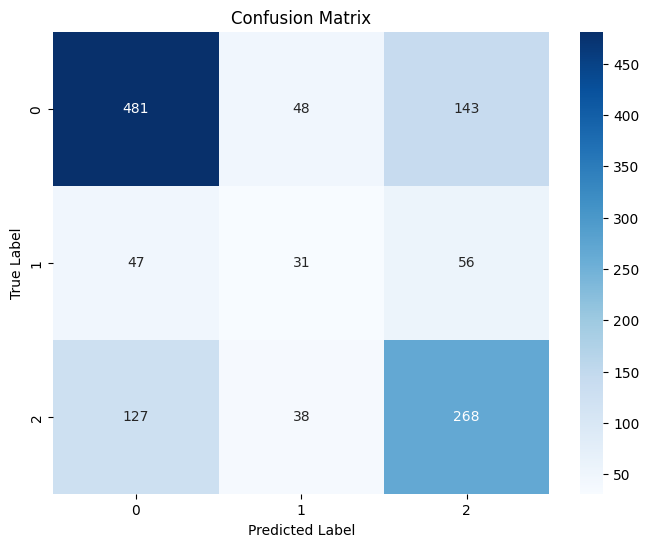

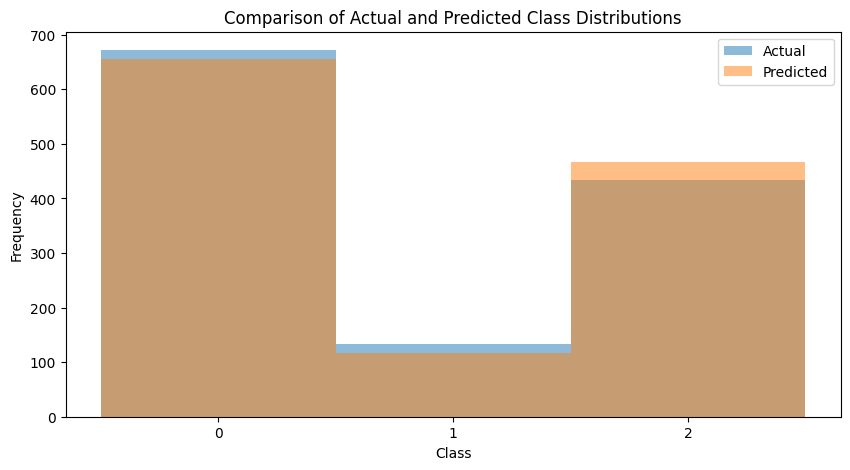

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test)

# Convert predictions from one-hot encoded to class labels if necessary
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test_categorical, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print(classification_report(y_test_labels, y_pred_labels))

cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(y_test_labels, bins=np.arange(-0.5, 3, 1), alpha=0.5, label='Actual')
plt.hist(y_pred_labels, bins=np.arange(-0.5, 3, 1), alpha=0.5, label='Predicted')
plt.xticks([0, 1, 2])
plt.title('Comparison of Actual and Predicted Class Distributions')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Section 2
* In this section, we're going to implement different neural network. It's train the data one by one.
* First train the image feature data then combined with sentences vectors data and train it again

In [ ]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

# Assuming 'features_im1', 'features_im2', and 'sentence_embeddings' are your initial datasets
before_features_tensor = torch.tensor(features_im1, dtype=torch.float32)
after_features_tensor = torch.tensor(features_im2, dtype=torch.float32)
bert_encoded_sentences_tensor = torch.tensor(sentence_embeddings, dtype=torch.float32)

# Normalize the features
def normalize(tensor):
    return tensor / tensor.norm(dim=1, keepdim=True)

before_features_norm = normalize(before_features_tensor)
after_features_norm = normalize(after_features_tensor)

before_features_norm = before_features_norm.repeat_interleave(3, dim=0)
after_features_norm = after_features_norm.repeat_interleave(3, dim=0)

# Combine before and after image features
combined_image_features = torch.cat([before_features_norm, after_features_norm], dim=1).numpy()

# Assume 'slider_values' are your target labels
X_train, X_testVal, y_train, y_testVal = train_test_split(combined_image_features, slider_values, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_testVal, y_testVal, test_size=0.66, random_state=42, shuffle=True)

In [ ]:
from keras.layers import Input
from keras.models import Model
input_shape = 4096  # Combined shape of before and after images
output_shape = 768  # Desired feature vector size

input_layer = Input(shape=(input_shape,))
x = Dense(1024, kernel_regularizer=regularizers.l2(0.001))(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

# Additional layers can be added here

x = Dense(512, kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)

x = Dense(256, kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)

# Output layer
output_layer = Dense(output_shape, activation='relu')(x)

model_image = Model(inputs=input_layer, outputs=output_layer)

optimizer = Adam(learning_rate=0.00005)
model_image.compile(loss='mse', optimizer=optimizer, metrics=['mean_absolute_error'])

model_image.summary()

# Fit model
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model_image.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 1024)              4195328   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                             

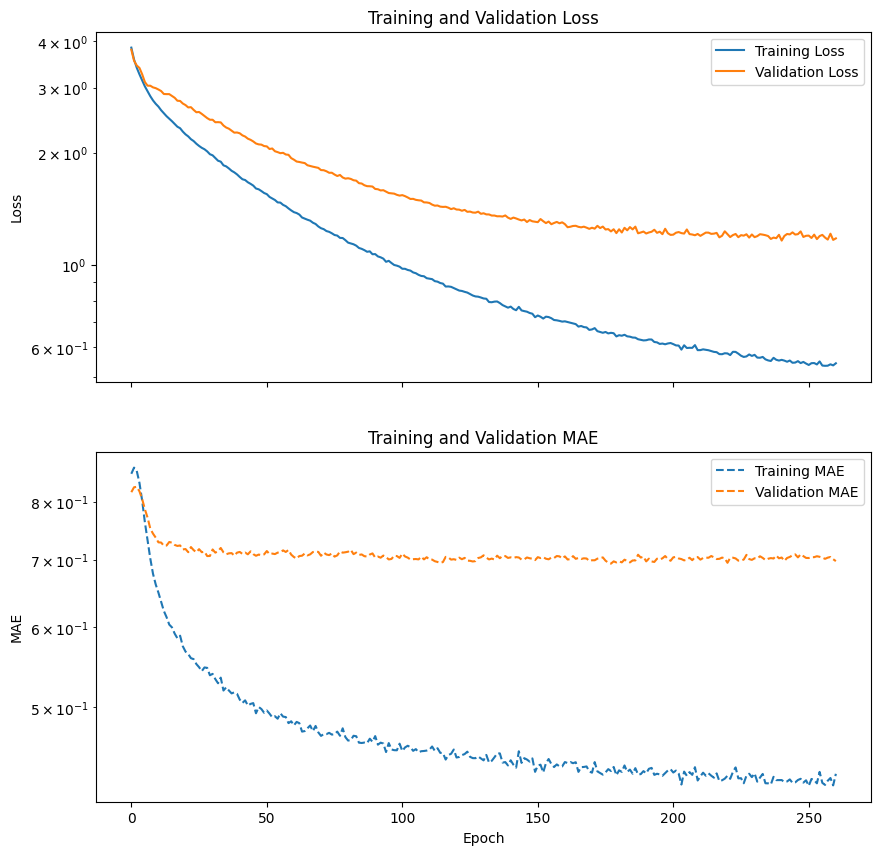

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert model history into a Pandas DataFrame
losses_df = pd.DataFrame(model_image.history.history)
# Plot the losses and MSE on separate subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# Loss plot
axes[0].plot(losses_df['loss'], label='Training Loss')
axes[0].plot(losses_df['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_yscale('log')

# MSE plot
axes[1].plot(losses_df['mean_absolute_error'], label='Training MAE', linestyle='--')
axes[1].plot(losses_df['val_mean_absolute_error'], label='Validation MAE', linestyle='--')
axes[1].set_title('Training and Validation MAE')
axes[1].set_ylabel('MAE')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].set_yscale('log')

# Show the plot
plt.show()

In [ ]:
transformed_image_features = model_image.predict(combined_image_features)
combined_features_step2 = np.concatenate([transformed_image_features, bert_encoded_sentences_tensor.numpy()], axis=1)

# Split the combined features for training the second model
X_train_combined, X_testVal_combined, _, _ = train_test_split(combined_features_step2, slider_values, test_size=0.3, random_state=42, shuffle=True)
X_val_combined, X_test_combined, _, _ = train_test_split(X_testVal_combined, y_testVal, test_size=0.66, random_state=42, shuffle=True)

# Prepare categorical labels for the second model
y_train_categorical = to_categorical(y_train, num_classes=3)
y_val_categorical = to_categorical(y_val)
y_test_categorical = to_categorical(y_test)

196/196 [==============================] - 1s 2ms/step


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

model_final = Sequential()
model_final.add(Dense(1024, input_dim=combined_features_step2.shape[1], kernel_regularizer=regularizers.l2(0.001)))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))
model_final.add(Dropout(0.5))

model_final.add(Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))
model_final.add(Dropout(0.3))

model_final.add(Dense(256, kernel_regularizer=regularizers.l2(0.001)))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))
model_final.add(Dropout(0.2))

model_final.add(Dense(3, activation='softmax'))
optimizer = Adam(learning_rate=0.00005)
model_final.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_seperated_nn.h5', monitor='val_loss', save_best_only=True)

# Fit the final model
model_final.fit(X_train_combined, y_train_categorical,
                epochs=500,
                batch_size=32,
                validation_data=(X_val_combined, y_val_categorical),
                callbacks=[early_stop, model_checkpoint],
                class_weight=class_weight_dict)

# Evaluate the model
loss, accuracy = model_final.evaluate(X_test_combined, y_test_categorical)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/500
133/137 [============================>.] - ETA: 0s - loss: 3.1254 - accuracy: 0.6499

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


137/137 [==============================] - 7s 25ms/step - loss: 3.1292 - accuracy: 0.6508 - val_loss: 3.7564 - val_accuracy: 0.5133
Epoch 2/500
137/137 [==============================] - 2s 16ms/step - loss: 3.0487 - accuracy: 0.6606 - val_loss: 3.9210 - val_accuracy: 0.5243
Epoch 3/500
137/137 [==============================] - 2s 16ms/step - loss: 2.9879 - accuracy: 0.6638 - val_loss: 3.9702 - val_accuracy: 0.5243
Epoch 4/500
137/137 [==============================] - 2s 12ms/step - loss: 2.9941 - accuracy: 0.6620 - val_loss: 3.7914 - val_accuracy: 0.5071
Epoch 5/500
137/137 [==============================] - 1s 8ms/step - loss: 2.9593 - accuracy: 0.6581 - val_loss: 3.9420 - val_accuracy: 0.5275
Epoch 6/500
137/137 [==============================] - 1s 8ms/step - loss: 2.9373 - accuracy: 0.6691 - val_loss: 3.8367 - val_accuracy: 0.5118
Epoch 7/500
137/137 [==============================] - 1s 7ms/step - loss: 2.8901 - accuracy: 0.6739 - val_loss: 3.8811 - val_accuracy: 0.5133
Epoch 8

39/39 [==============================] - 0s 2ms/step
Accuracy: 0.5835351089588378
              precision    recall  f1-score   support

           0       0.66      0.74      0.69       672
           1       0.19      0.13      0.16       134
           2       0.54      0.48      0.51       433

    accuracy                           0.58      1239
   macro avg       0.46      0.45      0.45      1239
weighted avg       0.56      0.58      0.57      1239



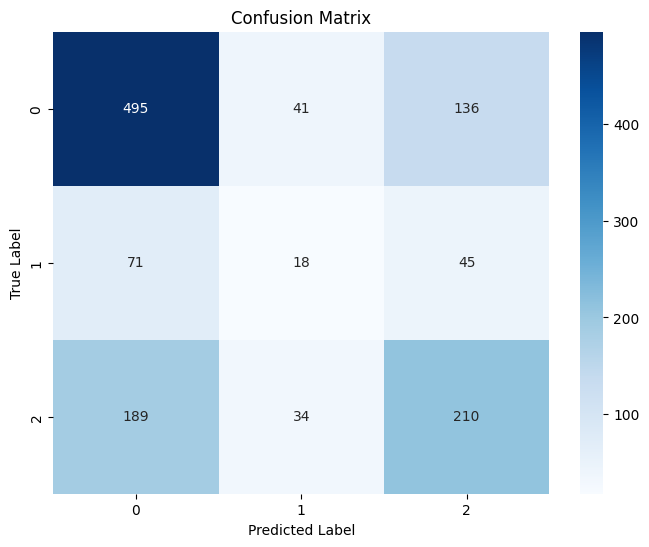

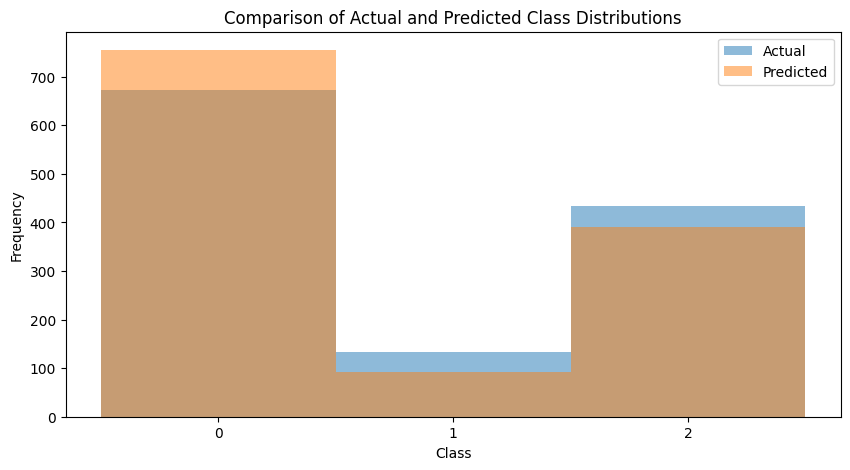

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

y_pred = model_final.predict(X_test_combined)

# Convert predictions from one-hot encoded to class labels if necessary
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test_categorical, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)
print(classification_report(y_test_labels, y_pred_labels))

cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(y_test_labels, bins=np.arange(-0.5, 3, 1), alpha=0.5, label='Actual')
plt.hist(y_pred_labels, bins=np.arange(-0.5, 3, 1), alpha=0.5, label='Predicted')
plt.xticks([0, 1, 2])
plt.title('Comparison of Actual and Predicted Class Distributions')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.legend()
plt.show()